# Sandbox for simulating and predicting bivariate Guassian random fields

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmcrameri import cm

import fields
import model
import sim
import prediction
import plot

%matplotlib inline

In [3]:
vals = [1.0, 1.0, 1.5, 1.5, 1.5, 0.2, 0.2, 0.2, 0.0, 0.0, -0.5]
true_params = model.MaternParams().set_values(vals)
true_params.set_bounds(len_scale = (1e-8, 1.5))
true_mod = model.MultivariateMatern(params=true_params)
true_mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.0,"(0.4, 3.5)"
1,sigma_22,1.0,"(0.4, 3.5)"
2,nu_11,1.5,"(0.2, 3.5)"
3,nu_12,1.5,"(0.2, 3.5)"
4,nu_22,1.5,"(0.2, 3.5)"
5,len_scale_11,0.2,"(1e-08, 1.5)"
6,len_scale_12,0.2,"(1e-08, 1.5)"
7,len_scale_22,0.2,"(1e-08, 1.5)"
8,nugget_11,0.0,"(0.0, 0.2)"
9,nugget_22,0.0,"(0.0, 0.2)"


In [4]:
grid = sim.CartesianGrid(xcount=51, ycount=51)
rf = sim.BivariateRandomField(true_mod, grid, seed=1)
samples = rf.sample(frac=0.1, epsilon=0.1)

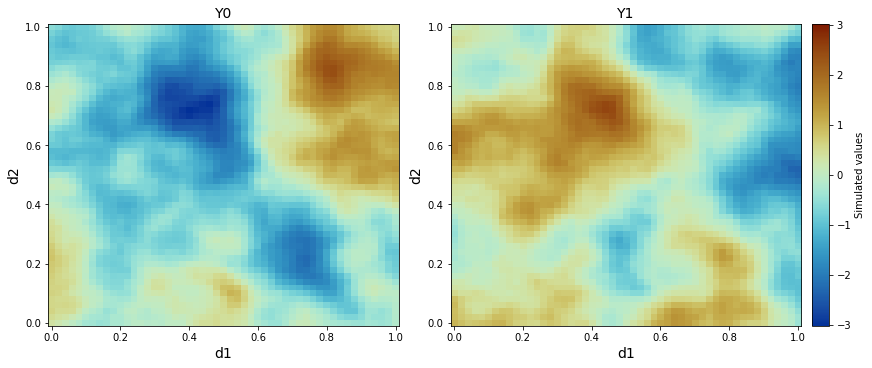

In [5]:
ds_full_fields = rf.to_xarray()
plot.plot_samples(ds_full_fields, fontsize=14)

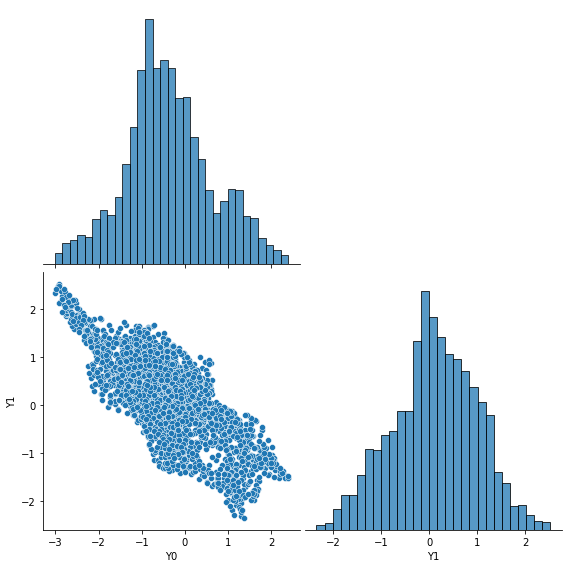

In [6]:
for i, df in enumerate(rf.fields):
    df.rename(columns={"value": f"Y{i}"}, inplace=True)

df_full_fields = pd.merge(*rf.fields, how="outer")
sns.pairplot(df_full_fields, vars=["Y0", "Y1"], corner=True, height=4)

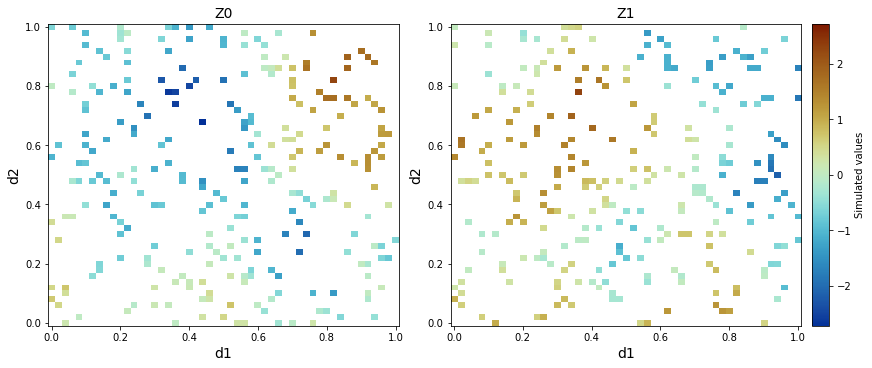

In [7]:
ds_samp = rf.to_xarray(samples)
plot.plot_samples(ds_samp, fontsize=14)

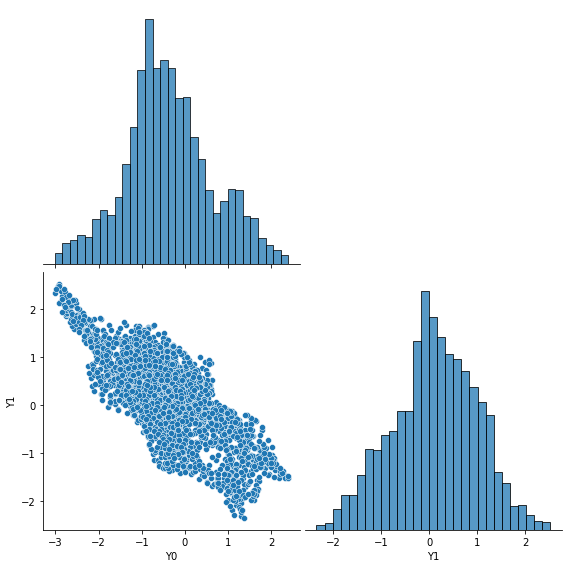

In [8]:
df_full_samp = pd.merge(*samples, how="outer")
sns.pairplot(df_full_fields, vars=["Y0", "Y1"], corner=True, height=4)

## Multivariate Prediction
---

In [9]:
pcoords = grid.coords
mf = rf.to_fields(samples)
P = prediction.Predictor(true_mod, mf, fast_dist=False, dist_units=None)
ds_cokrig = P(1, pcoords, max_dist=0.2, postprocess=False)
ds_cokrig

/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:216: UserWarning: Invalid model at prediction location [0.   0.08]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:205: RuntimeWarning: invalid value encountered in sqrt
  pred_std = np.sqrt(c0 - np.matmul(cov_weights, local_pred_cov))
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:216: UserWarning: Invalid model at prediction location [0.   0.12]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:216: UserWarning: Invalid model at prediction location [0.   0.56]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:216: UserWarning: Invalid model at prediction location [0.  0.8]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projec

<xarray.Dataset>
Dimensions:   (x: 51, y: 51)
Coordinates:
  * x         (x) float64 0.0 0.02 0.04 0.06 0.08 ... 0.92 0.94 0.96 0.98 1.0
  * y         (y) float64 0.0 0.02 0.04 0.06 0.08 ... 0.92 0.94 0.96 0.98 1.0
Data variables:
    pred      (x, y) float64 0.9159 0.9162 0.9252 ... -0.9499 -0.8103 -0.6542
    pred_err  (x, y) float64 0.3193 0.2351 0.149 0.06983 ... 0.2347 0.277 0.349

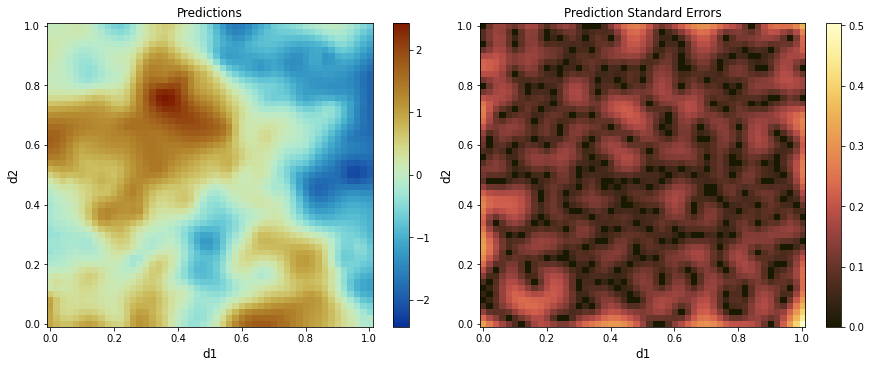

In [10]:
plot.plot_sim_pred(ds_pred)

In [11]:
df_cokrig = (
    ds_pred.to_dataframe()
    .reset_index()
    .dropna(subset=["pred"])
    .merge(samples[1], on=["x", "y"], how="right")
)
df_cokrig["diff"] = df_cokrig["Z1"] - df_cokrig["pred"]
df_cokrig[["diff", "pred_err"]].describe()

,diff,pred_err
count,2.610000e+02,2.610000e+02
mean,-1.479084e-16,4.947412e-09
std,8.546093e-15,6.516853e-09
min,-2.597922e-14,0.000000e+00
25%,-4.884981e-15,0.000000e+00
50%,1.387779e-16,0.000000e+00
75%,4.440892e-15,1.053671e-08
max,3.566591e-14,1.825012e-08


## Univariate Prediction
---

In [12]:
bi_vals = true_mod.params.get_values()[[1, 4, 7, 9]]
tmod_uni = model.MultivariateMatern(n_procs=1)
tmod_uni.params.set_values(bi_vals)
tmod_uni.params.set_bounds(len_scale = (1e-2, 4))
tmod_uni.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.0,"(0.4, 3.5)"
1,nu_11,1.5,"(0.2, 3.5)"
2,len_scale_11,0.2,"(0.01, 4)"
3,nugget_11,0.0,"(0.0, 0.2)"


In [13]:
pcoords = grid.coords
mf = rf.to_fields(samples, i=1)
P = prediction.Predictor(tmod_uni, mf, fast_dist=False, dist_units=None)
ds_krig = P(0, pcoords, max_dist=0.2, postprocess=False)
ds_krig

/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:216: UserWarning: Invalid model at prediction location [0.   0.08]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:216: UserWarning: Invalid model at prediction location [0.   0.12]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:216: UserWarning: Invalid model at prediction location [0.   0.56]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:216: UserWarning: Invalid model at prediction location [0.  0.8]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:216: UserWarning: Invalid model at prediction location [0.   0.94]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Project

<xarray.Dataset>
Dimensions:   (x: 51, y: 51)
Coordinates:
  * x         (x) float64 0.0 0.02 0.04 0.06 0.08 ... 0.92 0.94 0.96 0.98 1.0
  * y         (y) float64 0.0 0.02 0.04 0.06 0.08 ... 0.92 0.94 0.96 0.98 1.0
Data variables:
    pred      (x, y) float64 0.9416 0.934 0.958 ... -0.9408 -0.8017 -0.6466
    pred_err  (x, y) float64 0.3479 0.2519 0.1554 ... 0.2349 0.2772 0.3494

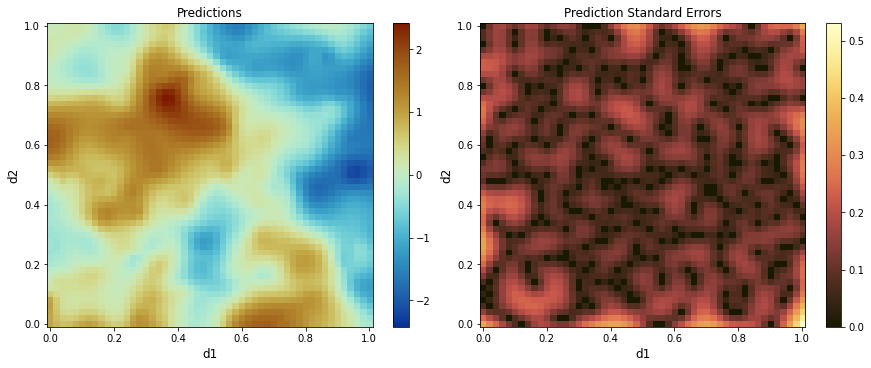

In [14]:
plot.plot_sim_pred(ds_krig)

In [15]:
df_krig = (
    ds_krig.to_dataframe()
    .reset_index()
    .dropna(subset=["pred"])
    .merge(samples[1], on=["x", "y"], how="right")
)
df_krig["diff"] = df_krig["Z1"] - df_krig["pred"]
df_krig[["diff", "pred_err"]].describe()

,diff,pred_err
count,2.610000e+02,2.610000e+02
mean,2.235866e-16,3.991409e-09
std,3.496960e-15,5.864676e-09
min,-1.604272e-14,0.000000e+00
25%,-9.992007e-16,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,1.332268e-15,1.053671e-08
max,1.632028e-14,1.825012e-08


## Prediction Comparison

In [16]:
df_cokrig_err = (
    ds_cokrig["pred_err"].to_dataframe().reset_index().dropna()
)
df_krig_err = (
    ds_krig["pred_err"].to_dataframe().reset_index().dropna()
)
df_err_ratio = pd.merge(
    df_cokrig_err,
    df_krig_err,
    on=["x", "y"],
    how="outer",
    suffixes=["_cokrig", "_krig"],
)
df_err_ratio["ratio"] = df_err_ratio["pred_err_cokrig"] / df_err_ratio["pred_err_krig"]
df_err_ratio["ratio"][df_err_ratio["ratio"] == 0.0] = np.nan
with pd.option_context("mode.use_inf_as_null", True):
    df_err_ratio.fillna(1, inplace=True)

da_err_ratio = df_err_ratio.set_index(["x", "y"]).to_xarray()["ratio"]

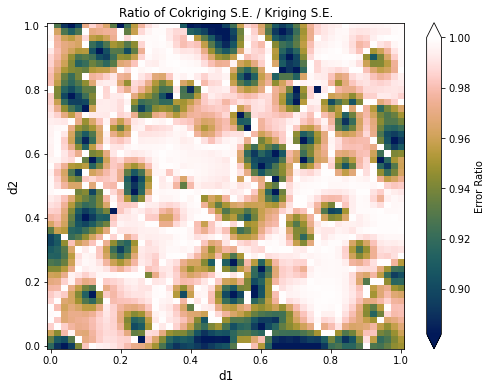

In [18]:
title = "Ratio of Cokriging S.E. / Kriging S.E."
plot.plot_err_ratio(da_err_ratio, cmap=cm.batlowW, robust=True, title=title)